# Federated Learning

I don't know why, but Google colab failed to install the tensorflow-federated library. Becuase It does not work in Google Colab, we worked in jupyter notebook. So, i recommend downloading attach file and open in jupyter notebook please.  

Latest version of tensorflow-federated library package is 0.48.0, but we still use 0.17.0. we could not upgrade tff version because of environment.

First week, we looked at a UCI-HAR dataset. There are 30 subjects, which 70% of them are in train set and 30% are in test set. We had a debate about case that when we had new clients or we didn't have new clients.(clients meaning devices)


[Reference 1](https://www.tensorflow.org/federated/tutorials/federated_learning_for_image_classification?hl=ko)
[Reference 2](https://github.com/CS-savvy/experiment_with_tf_federated/blob/master/train_tff.py)

Using already preprocessed <br>
[Dataset Link](https://www.kaggle.com/datasets/uciml/human-activity-recognition-with-smartphones)

# Set up

In [1]:
import sys
sys.version_info

sys.version_info(major=3, minor=8, micro=13, releaselevel='final', serial=0)

In [2]:
import nest_asyncio
nest_asyncio.apply()

%load_ext tensorboard

In [3]:
import collections
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff
from matplotlib import pyplot as plt

In [4]:
tff.__version__

'0.17.0'

In [5]:
tf.__version__

'2.3.4'

# Data Preprocessing

In [6]:
train = pd.read_csv('train.csv')

In [7]:
test = pd.read_csv('test.csv')

In [8]:
train.subject.unique()

array([ 1,  3,  5,  6,  7,  8, 11, 14, 15, 16, 17, 19, 21, 22, 23, 25, 26,
       27, 28, 29, 30], dtype=int64)

In [9]:
test.subject.unique()

array([ 2,  4,  9, 10, 12, 13, 18, 20, 24], dtype=int64)

In [10]:
df = pd.concat([train, test]).reset_index(drop=True)
df.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
label_encoded = le.fit_transform(df['Activity'])

In [12]:
le.classes_

array(['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

In [13]:
df['Activity'] = label_encoded
df

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,2
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,2
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,2
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,2
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10294,0.310155,-0.053391,-0.099109,-0.287866,-0.140589,-0.215088,-0.356083,-0.148775,-0.232057,0.185361,...,-0.750809,-0.337422,0.346295,0.884904,-0.698885,-0.651732,0.274627,0.184784,24,5
10295,0.363385,-0.039214,-0.105915,-0.305388,0.028148,-0.196373,-0.373540,-0.030036,-0.270237,0.185361,...,-0.700274,-0.736701,-0.372889,-0.657421,0.322549,-0.655181,0.273578,0.182412,24,5
10296,0.349966,0.030077,-0.115788,-0.329638,-0.042143,-0.250181,-0.388017,-0.133257,-0.347029,0.007471,...,-0.467179,-0.181560,0.088574,0.696663,0.363139,-0.655357,0.274479,0.181184,24,5
10297,0.237594,0.018467,-0.096499,-0.323114,-0.229775,-0.207574,-0.392380,-0.279610,-0.289477,0.007471,...,-0.617737,0.444558,-0.819188,0.929294,-0.008398,-0.659719,0.264782,0.187563,24,5


In [14]:
X = df.iloc[:,:-1]
y = df['Activity']

In [15]:
X

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10294,0.310155,-0.053391,-0.099109,-0.287866,-0.140589,-0.215088,-0.356083,-0.148775,-0.232057,0.185361,...,-0.376278,-0.750809,-0.337422,0.346295,0.884904,-0.698885,-0.651732,0.274627,0.184784,24
10295,0.363385,-0.039214,-0.105915,-0.305388,0.028148,-0.196373,-0.373540,-0.030036,-0.270237,0.185361,...,-0.320418,-0.700274,-0.736701,-0.372889,-0.657421,0.322549,-0.655181,0.273578,0.182412,24
10296,0.349966,0.030077,-0.115788,-0.329638,-0.042143,-0.250181,-0.388017,-0.133257,-0.347029,0.007471,...,-0.118854,-0.467179,-0.181560,0.088574,0.696663,0.363139,-0.655357,0.274479,0.181184,24
10297,0.237594,0.018467,-0.096499,-0.323114,-0.229775,-0.207574,-0.392380,-0.279610,-0.289477,0.007471,...,-0.205445,-0.617737,0.444558,-0.819188,0.929294,-0.008398,-0.659719,0.264782,0.187563,24


In [16]:
y

0        2
1        2
2        2
3        2
4        2
        ..
10294    5
10295    5
10296    5
10297    5
10298    5
Name: Activity, Length: 10299, dtype: int32

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=df.subject, random_state=42)

In [18]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(8239, 562) (8239,)
(2060, 562) (2060,)


In [19]:
for i in range(1, 31):
    X_train_sub = X_train[X_train['subject'] == i].iloc[:, :-1]
    y_train_sub = y_train[X_train['subject'] == i]
    train_file = pd.concat([X_train_sub, y_train_sub], axis=1)
    train_file.to_csv('datasets/train_file' + str(i) + '.txt', index=False)

In [20]:
for i in range(1, 31):
    X_test_sub = X_test[X_test['subject'] == i].iloc[:, :-1]
    y_test_sub = y_test[X_test['subject'] == i]
    test_file = pd.concat([X_test_sub, y_test_sub], axis=1)
    test_file.to_csv('datasets/test_file' + str(i) + '.txt', index=False)

# Tensorflow Data Creation

### Make Train set

In [21]:
client_train_dataset = collections.OrderedDict()
for i in range(1, 31):
    
    df = pd.read_csv('datasets/train_file' + str(i) + '.txt')
    x_train = df.iloc[:,:-1].values
    y_train = np.array(df.Activity)    
    
    client_name = "client_" + str(i)

    data = collections.OrderedDict((('label', y_train), ('pixels', x_train)))
    client_train_dataset[client_name] = data

In [22]:
train_dataset = tff.simulation.FromTensorSlicesClientData(client_train_dataset)

In [23]:
train_dataset.element_type_structure

OrderedDict([('label', TensorSpec(shape=(), dtype=tf.int64, name=None)),
             ('pixels',
              TensorSpec(shape=(561,), dtype=tf.float64, name=None))])

In [24]:
train_dataset.client_ids

['client_1',
 'client_2',
 'client_3',
 'client_4',
 'client_5',
 'client_6',
 'client_7',
 'client_8',
 'client_9',
 'client_10',
 'client_11',
 'client_12',
 'client_13',
 'client_14',
 'client_15',
 'client_16',
 'client_17',
 'client_18',
 'client_19',
 'client_20',
 'client_21',
 'client_22',
 'client_23',
 'client_24',
 'client_25',
 'client_26',
 'client_27',
 'client_28',
 'client_29',
 'client_30']

In [25]:
sample_dataset = train_dataset.create_tf_dataset_for_client(train_dataset.client_ids[0])

In [26]:
sample_element = next(iter(sample_dataset))

In [27]:
sample_element['label'].numpy()

0

In [28]:
sample_element['pixels'].numpy()

array([ 2.8526329e-01, -8.8888110e-03, -1.0374518e-01, -9.9549458e-01,
       -9.7982784e-01, -9.9541907e-01, -9.9580191e-01, -9.7867265e-01,
       -9.9550068e-01, -9.3775406e-01, -5.5991109e-01, -8.1312665e-01,
        8.4995073e-01,  6.9347377e-01,  8.4833835e-01, -9.8954416e-01,
       -9.9995907e-01, -9.9972268e-01, -9.9990149e-01, -9.9553290e-01,
       -9.7984054e-01, -9.9479481e-01, -4.7755006e-01, -3.2158971e-01,
       -5.1922580e-01,  1.8471273e-01, -8.1654752e-02, -2.2330096e-03,
        1.1818704e-01,  2.7345041e-01, -2.2666771e-01,  2.4823997e-01,
       -2.4649588e-01,  2.2365705e-01, -6.8945039e-02,  1.0976763e-01,
        3.3595921e-03,  1.3951068e-02, -1.5929713e-01,  7.8549045e-02,
       -7.5875146e-01, -4.5998244e-02,  9.9577290e-01, -9.9413600e-01,
       -9.7831578e-01, -9.8857181e-01, -9.9416991e-01, -9.8286882e-01,
       -9.8883099e-01, -8.2280100e-01, -6.6390056e-02,  9.8073541e-01,
       -7.0250277e-01, -3.2167846e-02,  9.9409287e-01, -4.9963631e-01,
      

# Data Transformation

In [29]:
NUM_ROUNDS = 10
NUM_EPOCHS = 10
BATCH_SIZE = 64
PREFETCH_BUFFER = 10
SHUFFLE_BUFFER = 100

def preprocess(dataset):

  def batch_format_fn(element):
    """Flatten a batch `pixels` and return the features as an `OrderedDict`."""

    return collections.OrderedDict(
        x=tf.reshape(element['pixels'], [-1, 561]),
        y=tf.reshape(element['label'], [-1, 1]))

  return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
      BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

In [30]:
preprocessed_sample_dataset = preprocess(sample_dataset)

In [31]:
sample_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(preprocessed_sample_dataset)))

In [32]:
sample_batch

OrderedDict([('x',
              array([[ 0.27090823, -0.01441297, -0.10652245, ..., -0.3167322 ,
                      -0.21772934, -0.32332877],
                     [ 0.28155172, -0.01611029, -0.14009252, ..., -0.80223567,
                       0.23416634,  0.03181717],
                     [ 0.26076161, -0.0353707 , -0.13730782, ..., -0.68758294,
                       0.31384947,  0.01011299],
                     ...,
                     [ 0.22622757, -0.05371894, -0.11252061, ..., -0.6951592 ,
                       0.3046152 ,  0.05993533],
                     [ 0.27672941, -0.01720955, -0.10563797, ...,  0.39713425,
                      -0.54467991, -0.43287147],
                     [ 0.28051914, -0.01884387, -0.21913175, ..., -0.70754928,
                       0.2919864 ,  0.07583892]])),
             ('y',
              array([[1],
                     [4],
                     [2],
                     [2],
                     [3],
                     [5],
         

In [33]:
len(sample_batch['x']), len(sample_batch['y'])

(64, 64)

In [34]:
def make_federated_data(client_data, client_ids):
    return [preprocess(client_data.create_tf_dataset_for_client(x)) for x in client_ids]

In [35]:
federated_train_data = make_federated_data(train_dataset, train_dataset.client_ids)

In [36]:
print('Number of client datasets: {l}'.format(l=len(federated_train_data)))
print('First dataset: {d}'.format(d=federated_train_data[0]))

Number of client datasets: 30
First dataset: <PrefetchDataset shapes: OrderedDict([(x, (None, 561)), (y, (None, 1))]), types: OrderedDict([(x, tf.float64), (y, tf.int64)])>


In [37]:
federated_train_data

[<PrefetchDataset shapes: OrderedDict([(x, (None, 561)), (y, (None, 1))]), types: OrderedDict([(x, tf.float64), (y, tf.int64)])>,
 <PrefetchDataset shapes: OrderedDict([(x, (None, 561)), (y, (None, 1))]), types: OrderedDict([(x, tf.float64), (y, tf.int64)])>,
 <PrefetchDataset shapes: OrderedDict([(x, (None, 561)), (y, (None, 1))]), types: OrderedDict([(x, tf.float64), (y, tf.int64)])>,
 <PrefetchDataset shapes: OrderedDict([(x, (None, 561)), (y, (None, 1))]), types: OrderedDict([(x, tf.float64), (y, tf.int64)])>,
 <PrefetchDataset shapes: OrderedDict([(x, (None, 561)), (y, (None, 1))]), types: OrderedDict([(x, tf.float64), (y, tf.int64)])>,
 <PrefetchDataset shapes: OrderedDict([(x, (None, 561)), (y, (None, 1))]), types: OrderedDict([(x, tf.float64), (y, tf.int64)])>,
 <PrefetchDataset shapes: OrderedDict([(x, (None, 561)), (y, (None, 1))]), types: OrderedDict([(x, tf.float64), (y, tf.int64)])>,
 <PrefetchDataset shapes: OrderedDict([(x, (None, 561)), (y, (None, 1))]), types: OrderedD

### Make Test set

In [38]:
client_test_dataset = collections.OrderedDict()
for i in range(1, 31):
    
    df = pd.read_csv('datasets/test_file' + str(i) + '.txt')
    x_test = df.iloc[:,:-1].values
    y_test = np.array(df.Activity)    
    
    client_name = "client_" + str(i)

    data = collections.OrderedDict((('label', y_test), ('pixels', x_test)))
    client_test_dataset[client_name] = data

In [39]:
test_dataset = tff.simulation.FromTensorSlicesClientData(client_test_dataset)

In [40]:
test_dataset.element_type_structure

OrderedDict([('label', TensorSpec(shape=(), dtype=tf.int64, name=None)),
             ('pixels',
              TensorSpec(shape=(561,), dtype=tf.float64, name=None))])

In [41]:
test_dataset.client_ids

['client_1',
 'client_2',
 'client_3',
 'client_4',
 'client_5',
 'client_6',
 'client_7',
 'client_8',
 'client_9',
 'client_10',
 'client_11',
 'client_12',
 'client_13',
 'client_14',
 'client_15',
 'client_16',
 'client_17',
 'client_18',
 'client_19',
 'client_20',
 'client_21',
 'client_22',
 'client_23',
 'client_24',
 'client_25',
 'client_26',
 'client_27',
 'client_28',
 'client_29',
 'client_30']

In [42]:
federated_test_data = make_federated_data(test_dataset, test_dataset.client_ids)

In [43]:
federated_test_data

[<PrefetchDataset shapes: OrderedDict([(x, (None, 561)), (y, (None, 1))]), types: OrderedDict([(x, tf.float64), (y, tf.int64)])>,
 <PrefetchDataset shapes: OrderedDict([(x, (None, 561)), (y, (None, 1))]), types: OrderedDict([(x, tf.float64), (y, tf.int64)])>,
 <PrefetchDataset shapes: OrderedDict([(x, (None, 561)), (y, (None, 1))]), types: OrderedDict([(x, tf.float64), (y, tf.int64)])>,
 <PrefetchDataset shapes: OrderedDict([(x, (None, 561)), (y, (None, 1))]), types: OrderedDict([(x, tf.float64), (y, tf.int64)])>,
 <PrefetchDataset shapes: OrderedDict([(x, (None, 561)), (y, (None, 1))]), types: OrderedDict([(x, tf.float64), (y, tf.int64)])>,
 <PrefetchDataset shapes: OrderedDict([(x, (None, 561)), (y, (None, 1))]), types: OrderedDict([(x, tf.float64), (y, tf.int64)])>,
 <PrefetchDataset shapes: OrderedDict([(x, (None, 561)), (y, (None, 1))]), types: OrderedDict([(x, tf.float64), (y, tf.int64)])>,
 <PrefetchDataset shapes: OrderedDict([(x, (None, 561)), (y, (None, 1))]), types: OrderedD

# Make Model

In [44]:
def create_keras_model():
    return tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(561,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(6, activation='softmax'),
    ])

In [45]:
def model_fn():

  keras_model = create_keras_model()
  return tff.learning.from_keras_model(
      keras_model,
      input_spec=preprocessed_sample_dataset.element_spec,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


In [46]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0))

In [47]:
print(iterative_process.initialize.type_signature.formatted_representation())

( -> <
  model=<
    trainable=<
      float32[561,128],
      float32[128],
      float32[128,6],
      float32[6]
    >,
    non_trainable=<>
  >,
  optimizer_state=<
    int64
  >,
  delta_aggregate_state=<
    value_sum_process=<>,
    weight_sum_process=<>
  >,
  model_broadcast_state=<>
>@SERVER)


In [48]:
state = iterative_process.initialize()

# Learning & Evaluation

In [49]:
state, metrics = iterative_process.next(state, federated_train_data)

In [50]:
def plot_graph(X, y, format = '-', label=''):
    plt.plot(X, y, format, label=label)
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.grid(True)

In [51]:
experiment_name = "UCI_HAR"

tff_train_acc = []
tff_val_acc = []
tff_train_loss = []
tff_val_loss = []

eval_model = None
for round_num in range(1, NUM_ROUNDS+1):
    state, tff_metrics = iterative_process.next(state, federated_train_data)
    eval_model = create_keras_model()
    eval_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1.0),
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                       metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

    state.model.assign_weights_to(eval_model)

    ev_result = eval_model.evaluate(x_test, y_test, verbose=0)
    print(f'Round {round_num:2d}, Metrics={tff_metrics}')
    print(f"Eval loss : {ev_result[0]} and Eval accuracy : {ev_result[1]}")
    tff_train_acc.append(float(tff_metrics['train']['sparse_categorical_accuracy']))
    tff_val_acc.append(ev_result[1])
    tff_train_loss.append(float(tff_metrics['train']['loss']))
    tff_val_loss.append(ev_result[0])

metric_collection = {"sparse_categorical_accuracy": tff_train_acc,
                     "val_sparse_categorical_accuracy": tff_val_acc,
                     "loss": tff_train_loss,
                     "val_loss": tff_val_loss}

if eval_model:
    eval_model.save('models/' + experiment_name + ".h5")
else:
    print("Training didn't started")
    exit()



Round  1, Metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.8350285), ('loss', 0.65927976)]))])
Eval loss : 0.6617637872695923 and Eval accuracy : 0.7792207598686218
Round  2, Metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.8764656), ('loss', 0.5064609)]))])
Eval loss : 0.5520229339599609 and Eval accuracy : 0.7662337422370911
Round  3, Metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.89648014), ('loss', 0.4159482)]))])
Eval loss : 0.4799972176551819 and Eval accuracy : 0.8181818127632141
Round  4, Metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', 

Round  5, Metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.91530526), ('loss', 0.31681353)]))])
Eval loss : 0.4090978801250458 and Eval accuracy : 0.8311688303947449


Round  6, Metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.92351013), ('loss', 0.28590104)]))])
Eval loss : 0.3859799802303314 and Eval accuracy : 0.8311688303947449


Round  7, Metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.9243112), ('loss', 0.2644545)]))])
Eval loss : 0.3689361810684204 and Eval accuracy : 0.8441558480262756


Round  8, Metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.9286564), ('loss', 0.24640693)]))])
Eval loss : 0.34309282898902893 and Eval accuracy : 0.8571428656578064


Round  9, Metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.9358053), ('loss', 0.22617112)]))])
Eval loss : 0.3386291265487671 and Eval accuracy : 0.8311688303947449


Round 10, Metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.9364729), ('loss', 0.21737176)]))])
Eval loss : 0.3230009377002716 and Eval accuracy : 0.8701298832893372


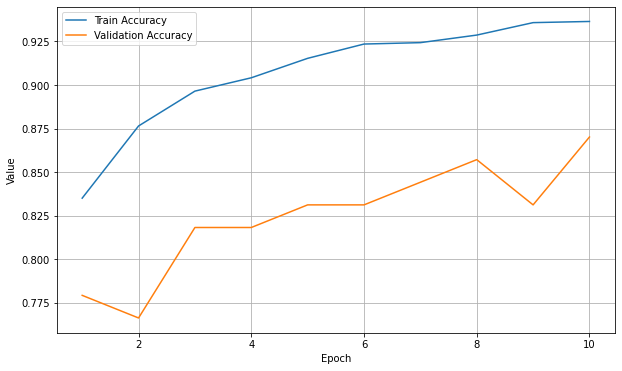

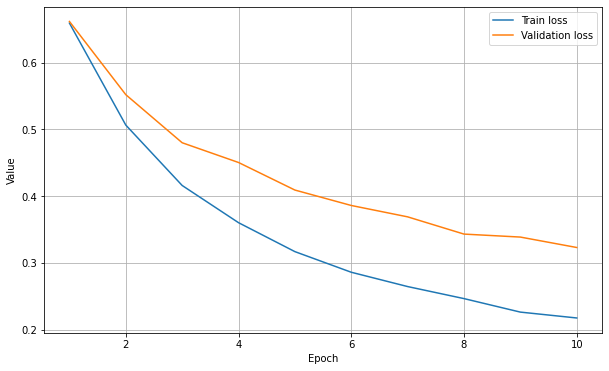

In [52]:
fig = plt.figure(figsize=(10, 6))
plot_graph(list(range(1, 11)), tff_train_acc, label='Train Accuracy')
plot_graph(list(range(1, 11)), tff_val_acc, label='Validation Accuracy')
plt.legend()
# plt.savefig(output_dir / "federated_model_Accuracy.png")

plt.figure(figsize=(10, 6))
plot_graph(list(range(1, 11)), tff_train_loss, label='Train loss')
plot_graph(list(range(1, 11)), tff_val_loss, label='Validation loss')
plt.legend()
# plt.savefig(output_dir / "federated_model_loss.png")